# Labor Evidenztheorie 



In [ ]:
!pip install py-dempster-shafer

## Emotionserkennung aus Sprache - die Daten

Einlesen einer Beispieldatei, in welcher eine Aufzeichnung von Emotionen enthalten ist. Aufgezeichnet werden Tonhöhe und Lautstärke sowie die Sprechgeschwindigkeit.

In [29]:
import pandas as pd

myPath = './data/'
file_path = f"{myPath}recording_voice_lab.csv"

# CSV-Datei einlesen
df = pd.read_csv(file_path, sep=';', decimal=',')
df

,time (0.1s),frequency,amplitude,speed (silben/sec)
0,0,961,0.007782,NaN
1,1,18,0.000793,NaN
2,2,478,0.006470,NaN
3,3,129,0.001038,NaN
4,4,42,0.000916,NaN
...,...,...,...,...
209,209,0,0.000366,NaN
210,210,1,0.000458,NaN
211,211,1,0.000305,NaN
212,212,0,0.000183,NaN


### Ein Blick auf die Daten

Diesmal mit grafischer Unterstützung.

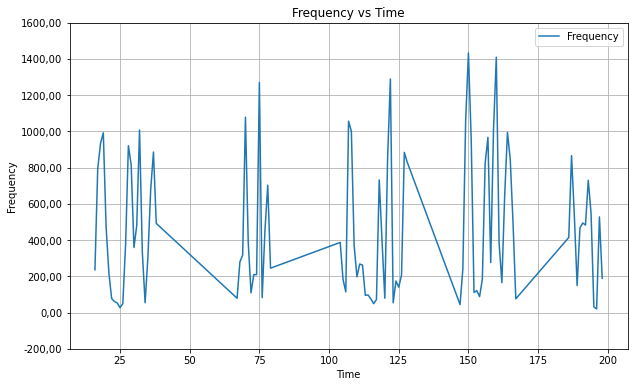

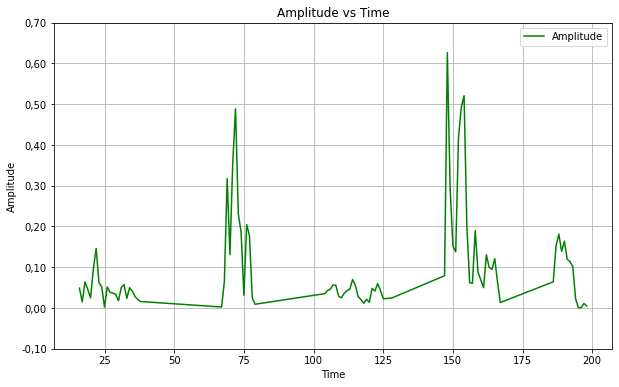

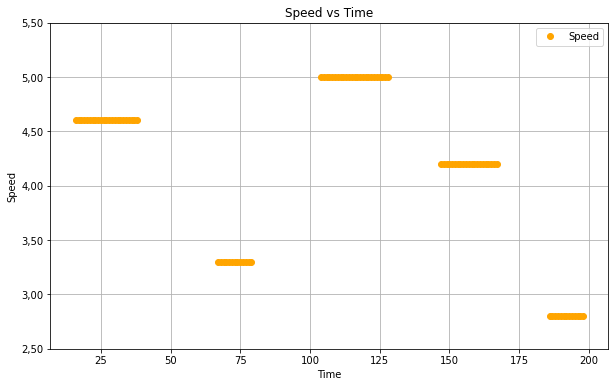

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Pfad zur CSV-Datei
myPath = './data/'
file_path = f"{myPath}recording_voice_lab.csv"

# CSV-Datei einlesen und Dezimaltrennzeichen sowie Separator angeben
df = pd.read_csv(file_path, sep=';', decimal=',')

# Spalten umbenennen
df.columns = ['t', 'f', 'a', 's']

# NaN-Werte ausschließen
df = df.dropna(subset=['t', 'f', 'a', 's'])

# Konvertieren der Spalten in NumPy-Arrays
time = df['t'].to_numpy()
frequency = df['f'].to_numpy()
amplitude = df['a'].to_numpy()
speed = df['s'].to_numpy()

# Funktion, um NaN-Werte zu maskieren und Lücken im Diagramm zu erzeugen
def mask_nan_values(x, y):
    mask = ~np.isnan(y)
    return x[mask], y[mask]
    
# Diagramm für 'f' (frequency) abhängig von 't' (time)
time_masked, frequency_masked = mask_nan_values(time, frequency)
plt.figure(figsize=(10, 6))
plt.plot(time_masked, frequency_masked, label='Frequency')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Frequency vs Time')
plt.legend()
plt.grid(True)
plt.yticks(ticks=plt.yticks()[0], labels=[f'{tick:.2f}'.replace('.', ',') for tick in plt.yticks()[0]])  # bessere y-Achsen-Beschriftung mit Komma
plt.show()

# Diagramm für 'a' (amplitude) abhängig von 't' (time)
time_masked, amplitude_masked = mask_nan_values(time, amplitude)
plt.figure(figsize=(10, 6))
plt.plot(time_masked, amplitude_masked, label='Amplitude', color='green')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Amplitude vs Time')
plt.legend()
plt.grid(True)
plt.yticks(ticks=plt.yticks()[0], labels=[f'{tick:.2f}'.replace('.', ',') for tick in plt.yticks()[0]])  # bessere y-Achsen-Beschriftung mit Komma
plt.show()

# Diagramm für 's' (speed) abhängig von 't' (time)
time_masked, speed_masked = mask_nan_values(time, speed)
plt.figure(figsize=(10, 6))
plt.plot(time_masked, speed_masked, 'o', linestyle='None', label='Speed', color='orange')  # nur Punkte anzeigen
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Speed vs Time')
plt.legend()
plt.grid(True)
plt.yticks(ticks=plt.yticks()[0], labels=[f'{tick:.2f}'.replace('.', ',') for tick in plt.yticks()[0]])  # bessere y-Achsen-Beschriftung mit Komma
plt.show()



## Bestimmung von Fuzzy Werten 

Um die in Aufgabe 1 beschriebene Einteilung vorzunehmen, muss man die Daten ansehen. Wann ist etwas "langsameres" Sprechen? Eine mögliche Lösung wird hier mal vorgeschlagen und dargestellt. Dies können Sie jedoch anders realisieren und anpassen. Im Bereich von 10% rund um den Mittelwert der Sprechgeschwindigkeit wird diese als "normal" angesehen. Die Zugehörigkeit zur Fuzzy-Mengenfunktion ist jedoch nur am Mittelwert selbst 1 und fällt dann bis zur Grenze des Toleranzbereichs linear ab. Ähnlich werden das Minimum und das Maximum der Datenmenge verwendet um Fuzzy Mengen zu berechnen. Winner-takes-all wird als Prinzip eingesetzt, der Wert jedoch mit ausgegeben, so dass man einen für die Evidenztheorie verwertbaren Konfidenzwert hat.

In [71]:

# Analysefunktion zur Berechnung des Mittelwerts und der Fuzzy-Mengenfunktionen
def analyze_speed(speed):
    mean_speed = np.nanmean(speed)
    min_speed = np.nanmin(speed)
    max_speed = np.nanmax(speed)
    range_10_percent = (max_speed - min_speed) * 0.10

    def slow(x):
        if x <= mean_speed:
            return (mean_speed - x) / (mean_speed - min_speed)
        return 0

    def fast(x):
        if x >= mean_speed:
            return (x - mean_speed) / (max_speed - mean_speed)
        return 0

    def medium(x):
        if mean_speed - range_10_percent <= x <= mean_speed:
            return (x - (mean_speed - range_10_percent)) / range_10_percent
        elif mean_speed < x <= mean_speed + range_10_percent:
            return (mean_speed + range_10_percent - x) / range_10_percent
        return 0

    return slow, medium, fast, mean_speed

### Bewertung der Sprechsequenzen

Nun kann man ansehen in welchen Bereichen welche Geschwindigkeit mit welcher Zuverlässigkeit vorlag.

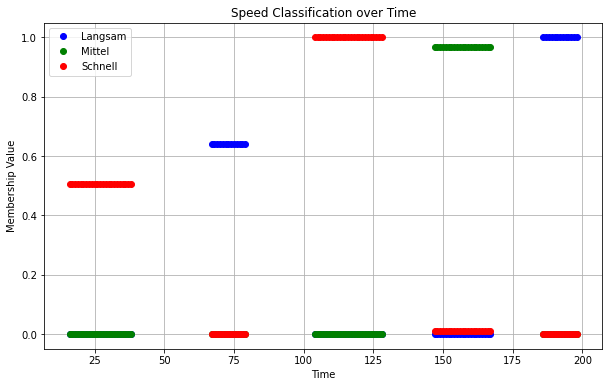

In [75]:

# Analyse der Geschwindigkeitsdaten
slow, medium, fast, mean_speed = analyze_speed(speed)

# Klassifikation der Geschwindigkeitswerte
slow_values = np.array([slow(v) for v in speed])
medium_values = np.array([medium(v) for v in speed])
fast_values = np.array([fast(v) for v in speed])

# Diagramm zur Darstellung der Klassifikation der Geschwindigkeitswerte
plt.figure(figsize=(10, 6))
plt.plot(time_masked, slow_values, 'o', linestyle='None', label='Langsam', color='blue')  # nur Punkte anzeigen
plt.plot(time_masked, medium_values, 'o', linestyle='None', label='Mittel', color='green')  # nur Punkte anzeigen
plt.plot(time_masked, fast_values, 'o', linestyle='None', label='Schnell', color='red')  # nur Punkte anzeigen
plt.xlabel('Time')
plt.ylabel('Membership Value')
plt.title('Speed Classification over Time')
plt.legend()
plt.grid(True)
plt.show()


Analog zu der Sprechgeschwindigkeit (speed) benötigen wir nun auch für die anderen Attribute eine Abbildung auf die entsprechende Klasse und einen Konfidenzwert. Dies wird dann in der Evidenztheorie als Eingabe benötigt. 


# Aufgabe:

Erstellen Sie Fuzzy Funktionen für die zwei weiteren Angaben (Frequenz und Amplitude).

In [92]:
def analyze_frequency(f):

    # Ihre Aufgabe
    
    return lower, normal, higher, mean_f

def analyze_amplitude(a):

    # Ihre Aufgabe
    
    return lower, normal, higher, mean_a


# Abbildung auf die Evidenztheorie

Wenn alle Eingaben als Fuzzy Mengen vorliegen, können wir dies nun auf die Evidenztheorie abbilden. Dazu folgen Sie den Basisinformationen der Aufgabenstellung.

In [ ]:
from pyds import MassFunction

Bestimmen Sie die Menge Omega

In [ ]:
omega = ''

# ... Ihre Aufgabe

Bestimmen Sie die Basismaße


In [ ]:
m1 = MassFunction({'':0.0, omega:1.0})
m2 = MassFunction({'':0.0, omega:1.0})
m3 = MassFunction({'':0.0, omega:1.0})

#### Die Hauptarbeit - Klassifikationsverfahren

Wie geht man vor? 
Zunächst: Was ist eigentlich die Eingabe?
Die drei Basismaße werden mit den eingegebenen Werten "gefüttert" ... und akkumuliert
Welche Emotion ist die plausibelste?


In [ ]:
# ... Ihre Arbeit

m12 = m1 & m2
m123 = m12 & m3

